# Load Model and Data

# Very Important: Check this out: is your dataset shuffled properly !!!!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
from dreamerv4.datasets import ShardedHDF5Dataset
from dreamerv4.models.utils import load_tokenizer
from dreamerv4.models.utils import load_denoiser
# DATA_PATH = "/home/mim-server/datasets/soar_data_sharded"
# DATA_PATH = "/home/mim-server/datasets/pushcube-play-hdf5"
DATA_PATH = "/home/mim-server/datasets/pushT/sharded"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resolution = (256, 256)

In [3]:
from hydra import initialize, compose
from omegaconf import OmegaConf
with initialize(version_base=None, config_path="../scripts/config"):
    cfg = compose(config_name="dynamics/pushT-large.yaml")

/home/mim-server/miniconda3/envs/dreamerv4/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'dynamics/pushT-large.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [4]:
dynamics_ckpt = "/home/mim-server/projects/rooholla/dreamerV4-UWM/checkpoints/dynamics/278145.pt"
cfg.dynamics_ckpt = dynamics_ckpt

In [53]:
tokenizer_ckpt="/home/mim-server/projects/rooholla/dreamer-v4-draft/checkpoints/tokenizer_ckpts/pushT.pt"
cfg.tokenizer_ckpt=tokenizer_ckpt

In [58]:
denoiser = load_denoiser(cfg, device, max_num_forward_steps=300)
tokenizer = load_tokenizer(cfg, device, max_num_forward_steps=300)
tokenizer = tokenizer.eval().cuda()
denoiser = denoiser.eval().cuda()

In [59]:
import mediapy
from torch.nn.functional import interpolate

dataset = ShardedHDF5Dataset(
        data_dir=DATA_PATH,
        window_size=64,
        stride=1,
        split='train',
        train_fraction=0.9,
        split_seed=123,
    )

# Arbitrary index into that episode
# batch = dataset[400]
imgs = batch["image"]  # (T, C, H, W)
actions = batch["action"][:,:cfg.denoiser.n_actions]  # (1, T, N_lat, D_lat)
# actions=torch.zeros_like(actions)
imgs = interpolate(imgs, resolution).to(device=device)[None] # resize to tokenizer resolution

with torch.no_grad():
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        latents = tokenizer.encode(imgs)
        imgs_recon = tokenizer.decode(latents)

from mediapy import show_video
def plotVideo(video):
    imgs = video.cpu().permute(0,2,3,1).to(torch.float32).numpy()*255
    imgs = imgs.astype('uint8')
    mediapy.show_video(imgs, fps=10)

plotVideo(imgs_recon[0])
plotVideo(imgs[0])

Train split: 64694 windows from 11 episodes


In [60]:
from dreamerv4.sampling import forward_dynamics_no_cache, AutoRegressiveForwardDynamics

In [61]:
import math
import numpy as np
import torch

def get_noise_index(tau, num_noise_levels):
    # map tau in [0, 1) to integer index in [0, N-1]
    # (training never uses exactly 1.0)
    tau = float(tau)
    tau = np.clip(tau, 0.0, (num_noise_levels - 1) / num_noise_levels)
    return int(tau * num_noise_levels)

def get_step_index(step_length, num_noise_levels):
    num_steps = int(round(1.0 / float(step_length)))
    max_pow2 = int(math.log2(num_noise_levels))
    # require power-of-two steps for your convention to be correct
    assert (num_steps & (num_steps - 1)) == 0, "num_diffusion_steps must be a power of two"
    step_index = max_pow2 - int(math.log2(num_steps))
    return step_index

@torch.no_grad()
def forward_dynamics_no_cache(
    denoiser,
    ctx_latents,                # (B, T_ctx, N_lat, D_lat)
    ctx_actions,                # (B, T_ctx, n_act)  (history only)
    num_pred_steps=1,
    num_diffusion_steps=4,      # MUST be power of two (2,4,8,...) and ideally divides num_noise_levels
    context_cond_tau=0.9,
):
    device = ctx_latents.device
    dtype = ctx_latents.dtype

    B, T_ctx, N_lat, D_lat = ctx_latents.shape
    assert ctx_actions.shape[0] == B and ctx_actions.shape[1] == T_ctx, \
        "ctx_actions must be (B, T_ctx, n_act)"

    n_act = ctx_actions.shape[-1]

    # pull num_noise_levels robustly (DDP wrapper vs raw module differs)
    # adjust this line to your actual object; this is the most common:
    num_noise_levels = denoiser.module.model.cfg.num_noise_levels if hasattr(denoiser, "module") else denoiser.model.cfg.num_noise_levels if hasattr(denoiser, "model") else denoiser.cfg.num_noise_levels

    # require power-of-two diffusion steps for step_index math
    assert (num_diffusion_steps & (num_diffusion_steps - 1)) == 0, "num_diffusion_steps must be power of two"

    T_total = T_ctx + num_pred_steps

    # 1) initialize pure noise at tau=0 for full sequence
    z = torch.randn(B, T_total, N_lat, D_lat, device=device, dtype=dtype)
    z_act = torch.randn(B, T_total, n_act, device=device, dtype=dtype)

    # 2) context conditioning with slight noise (obs + act)
    ctx_lat = ctx_latents.to(device=device, dtype=dtype)
    ctx_act = ctx_actions.to(device=device, dtype=dtype)

    # z_ctx ~ (1-tau_c) * N + tau_c * clean
    z_ctx = (1.0 - context_cond_tau) * torch.randn_like(ctx_lat) + context_cond_tau * ctx_lat
    a_ctx = (1.0 - context_cond_tau) * torch.randn_like(ctx_act) + context_cond_tau * ctx_act

    z[:, :T_ctx] = z_ctx
    z_act[:, :T_ctx] = a_ctx

    # 3) fixed step size + indices
    step_size = 1.0 / float(num_diffusion_steps)
    step_idx = get_step_index(step_size, num_noise_levels)
    step_index_tensor = torch.full((B, T_total), step_idx, dtype=torch.long, device=device)

    tau_cond_idx = get_noise_index(context_cond_tau, num_noise_levels)

    # choose tau indices for the integration steps
    # best if num_noise_levels % num_diffusion_steps == 0 so indices land exactly on the grid
    stride = num_noise_levels // num_diffusion_steps
    use_grid_aligned = (num_noise_levels % num_diffusion_steps == 0)

    for k in range(num_diffusion_steps):
        if use_grid_aligned:
            tau_current_idx = k * stride
            tau_current = tau_current_idx / float(num_noise_levels)
        else:
            tau_current = k / float(num_diffusion_steps)
            tau_current_idx = get_noise_index(tau_current, num_noise_levels)

        tau_index_tensor = torch.full((B, T_total), tau_current_idx, dtype=torch.long, device=device)
        tau_index_tensor[:, :T_ctx] = tau_cond_idx  # context frames stay at tau_c

        # denoise (act uses (B,T,n_act), obs uses (B,T,N_lat,D_lat))
        z_hat, act_hat = denoiser(
            noisy_obs=z,
            noisy_act=z_act,
            obs_sigma_idx=tau_index_tensor,
            obs_step_idx=step_index_tensor,
            act_sigma_idx=tau_index_tensor,
            act_step_idx=step_index_tensor,
        )
        act_hat = act_hat.squeeze(-2)  # (B,T,n_act)

        # v = (x_hat - x_tau) / (1 - tau)
        denom = (1.0 - tau_current)
        # denom never hits 0 because tau_current < 1
        v_obs = (z_hat - z) / denom
        v_act = (act_hat - z_act) / denom

        # integrate only future frames
        z[:, T_ctx:] = z[:, T_ctx:] + (v_obs * step_size)[:, T_ctx:]
        z_act[:, T_ctx:] = z_act[:, T_ctx:] + (v_act * step_size)[:, T_ctx:]

    # return integrated estimate (closest to x_1)
    return z[:, T_ctx:], z_act[:, T_ctx:]

In [78]:
num_pred_steps=12
latents_ctx = latents[:, :8, ...]
cond_actions = actions[:latents_ctx.shape[1]][None]
with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
    z, act = forward_dynamics_no_cache(denoiser, 
                                latents_ctx,
                                cond_actions,
                                num_pred_steps=num_pred_steps,
                                num_diffusion_steps=4)

    with torch.no_grad():
        img_pred = tokenizer.decode(z)


plotVideo(img_pred[0].to(torch.float32))

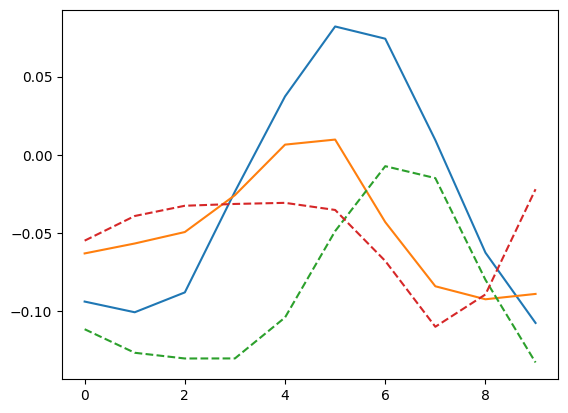

In [35]:
import matplotlib.pyplot as plt
plt.plot(act.cpu().to(torch.float32).cpu().numpy().squeeze())
plt.plot(actions[latents_ctx.shape[1]:latents_ctx.shape[1]+num_pred_steps][None].cpu().numpy().squeeze(), '--')

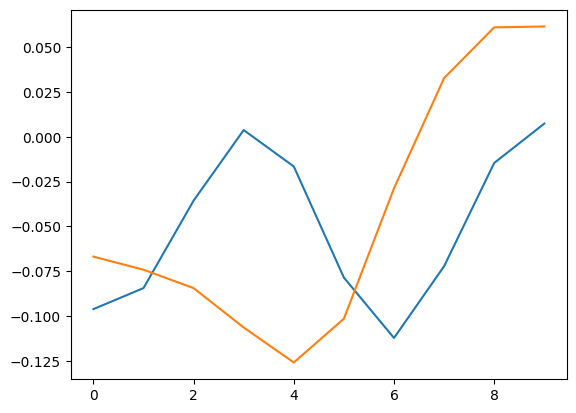

In [23]:
import matplotlib.pyplot as plt
plt.plot(act.cpu().to(torch.float32).numpy().squeeze())
# plt.plot(actions.cpu().to(torch.float32).numpy().squeeze())

In [79]:
import math
import numpy as np
import torch

def get_noise_index(tau, num_noise_levels):
    # tau in [0, 1) -> idx in [0, N-1]
    tau = float(tau)
    tau = np.clip(tau, 0.0, (num_noise_levels - 1) / num_noise_levels)
    return int(tau * num_noise_levels)

def get_step_index(step_length, num_noise_levels):
    num_steps = int(round(1.0 / float(step_length)))
    assert (num_steps & (num_steps - 1)) == 0, "num_diffusion_steps must be a power of two"
    max_pow2 = int(math.log2(num_noise_levels))
    return max_pow2 - int(math.log2(num_steps))  # your convention

@torch.no_grad()
def world_model_rollout_no_cache(
    denoiser,
    ctx_latents,                 # (B, T_ctx, N_lat, D_lat)
    actions,                     # (B, T_ctx + T_pred, n_act)  CLEAN actions provided
    num_pred_steps=1,
    num_diffusion_steps=4,       # power of two recommended
    context_cond_tau=0.9,        # slight noise on context obs for robustness
):
    device = ctx_latents.device
    dtype  = ctx_latents.dtype

    B, T_ctx, N_lat, D_lat = ctx_latents.shape
    assert actions.shape[0] == B
    assert actions.shape[1] == T_ctx + num_pred_steps, \
        "actions must be (B, T_ctx + num_pred_steps, n_act) for world-model rollout"
    n_act = actions.shape[-1]
    actions = actions.to(device=device, dtype=dtype)

    # --- get num_noise_levels from your object (adjust if yours differs) ---
    # Common cases: DDP(Wrapper(model=DreamerV4Denoiser)) or raw DreamerV4Denoiser
    if hasattr(denoiser, "module"):
        cfg = denoiser.module.model.cfg if hasattr(denoiser.module, "model") else denoiser.module.cfg
    else:
        cfg = denoiser.model.cfg if hasattr(denoiser, "model") else denoiser.cfg

    num_noise_levels = int(cfg.num_noise_levels)
    max_pow2 = int(math.log2(num_noise_levels))

    assert (num_diffusion_steps & (num_diffusion_steps - 1)) == 0, "num_diffusion_steps must be power of two"

    T_total = T_ctx + num_pred_steps

    # 1) initialize obs latents as pure noise for all frames
    z = torch.randn(B, T_total, N_lat, D_lat, device=device, dtype=dtype)

    # 2) context conditioning for obs (slight noise)
    latents_cond = (1.0 - context_cond_tau) * torch.randn_like(ctx_latents) + context_cond_tau * ctx_latents
    z[:, :T_ctx] = latents_cond

    # 3) actions are CLEAN and fixed (no diffusion on actions)
    # denoiser expects noisy_act as (B,T,n_act)
    z_act = actions

    # 4) step indices
    step_size = 1.0 / float(num_diffusion_steps)
    obs_step_idx_val = get_step_index(step_size, num_noise_levels)
    obs_step_idx = torch.full((B, T_total), obs_step_idx_val, dtype=torch.long, device=device)

    # actions: treat as "clean conditioning"
    # tau index for clean ≈ 1 - d_min => N-1
    act_tau_idx_clean = num_noise_levels - 1
    act_tau_idx = torch.full((B, T_total), act_tau_idx_clean, dtype=torch.long, device=device)

    # actions: choose a stable step idx (we're not iterating diffusion on actions)
    act_step_idx_val = 0#max_pow2  # corresponds to d=1
    act_step_idx = torch.full((B, T_total), act_step_idx_val, dtype=torch.long, device=device)

    # context obs tau index (for the slightly noised context latents)
    obs_tau_idx_cond = get_noise_index(context_cond_tau, num_noise_levels)

    # prefer grid-aligned tau indices when possible
    use_grid_aligned = (num_noise_levels % num_diffusion_steps == 0)
    stride = num_noise_levels // num_diffusion_steps if use_grid_aligned else None

    # 5) denoise only OBS future frames
    for k in range(num_diffusion_steps):
        if use_grid_aligned:
            obs_tau_idx_cur = k * stride
            tau_cur = obs_tau_idx_cur / float(num_noise_levels)
        else:
            tau_cur = k / float(num_diffusion_steps)
            obs_tau_idx_cur = get_noise_index(tau_cur, num_noise_levels)

        obs_tau_idx = torch.full((B, T_total), obs_tau_idx_cur, dtype=torch.long, device=device)
        obs_tau_idx[:, :T_ctx] = obs_tau_idx_cond  # context stays at cond noise

        z_hat, _act_hat = denoiser(
            noisy_act=z_act,           # CLEAN conditioning
            noisy_obs=z,
            obs_sigma_idx=obs_tau_idx,
            obs_step_idx=obs_step_idx,
            act_sigma_idx=act_tau_idx,
            act_step_idx=act_step_idx,
        )

        # v = (x_hat - x_tau) / (1 - tau)
        denom = (1.0 - tau_cur)
        v = (z_hat - z) / denom

        # only update future frames
        z[:, T_ctx:] = z[:, T_ctx:] + (v * step_size)[:, T_ctx:]

    # return predicted future obs latents (and optionally all frames if you want)
    return z[:, T_ctx:]

In [98]:
num_pred_steps = 12
T_ctx = 2
num_diffusion_steps = 8

# Context latents: (T_ctx, N_lat, D_lat) -> (1, T_ctx, N_lat, D_lat)
latents_ctx = latents[:,:T_ctx, ...]

# Provide CLEAN actions for context + future:
# actions: (T, n_actions) -> take [0 : T_ctx + num_pred_steps] -> (1, T_ctx + num_pred_steps, n_actions)
cond_actions = torch.zeros_like(actions[: T_ctx + num_pred_steps, :][None])
cond_actions[:,0] = -0.15
# cond_actions = actions[: T_ctx + num_pred_steps, :][None]

with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    # Predict ONLY future latents: (1, num_pred_steps, N_lat, D_lat)
    z_future = world_model_rollout_no_cache(
        denoiser,
        latents_ctx,
        cond_actions,
        num_pred_steps=num_pred_steps,
        num_diffusion_steps=num_diffusion_steps,
        context_cond_tau=0.99,
    )

    # Decode future frames
    with torch.no_grad():
        img_pred = tokenizer.decode(z_future)

plotVideo(img_pred[0].to(torch.float32))

In [33]:
latents_ctx.shape

torch.Size([1, 4, 256, 32])

In [70]:
world = AutoRegressiveForwardDynamics(denoiser, tokenizer, device=device, dtype=torch.bfloat16)
with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    world.reset(imgs[:,:8], actions[:8][None])

In [71]:
latents = []
imgs_pred = []
for i in range(32):
    action_t = actions[world.current_frame_index][None]
    # action_t[:, 0] = 1
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        img = world.step(action_t)
    latents.append(world.current_z.clone())
    imgs_pred.append(img)
z = torch.cat(latents, dim=1)
imgs_pred = torch.stack(imgs_pred, dim=1)

In [72]:
with torch.no_grad(), torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    # z_decoded = tokenizer.decoder(world.latents_cond)
    z_decoded = tokenizer.decoder(z)
    imgs_recon = tokenizer.image_head(z_decoded)
    imgs_recon = (imgs_recon + 1.0) / 2.0  # [-1,1] → [0,1]
    imgs_recon = torch.clamp(imgs_recon, 0.0, 1.0)
plotVideo(imgs_recon[0])

In [48]:
plotVideo(imgs_pred[0])

In [12]:
import mediapy
from torch.nn.functional import interpolate

dataset = ShardedHDF5Dataset(
        data_dir=DATA_PATH,
        window_size=64,
        stride=1,
        split='train',
        train_fraction=0.9,
        split_seed=123,
    )

Train split: 64694 windows from 11 episodes


In [13]:
imgs1 = dataset[0]['image']
imgs2 = dataset[10]['image']

In [14]:
plotVideo(imgs1)

In [15]:
plotVideo(imgs2)

In [24]:
import random
random.shuffle(dataset.windows)

In [18]:
from dreamerv4.models.dynamics import build_spatial_attention_mask

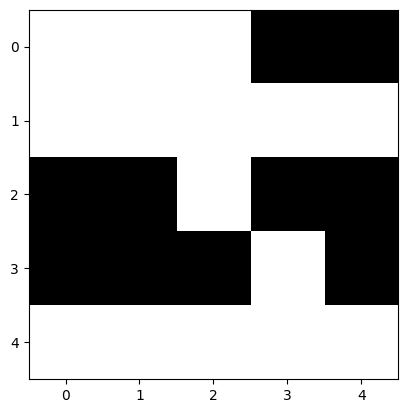

In [20]:
import matplotlib.pyplot as plt
mask_float = build_spatial_attention_mask(n_latent=1, n_register=1, n_image_control=1, n_action_control=1, n_action=1)
plt.imshow(mask_float != float('-inf'), cmap='gray')
# plt.xlim(0, mask.shape[0])
# plt.ylim(0, mask.shape[1])